In [2]:
# Standard library
import json
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
from xgboost import XGBClassifier

# TensorFlow / Keras
from tensorflow import keras
from tensorflow.keras import layers

2026-01-08 14:56:40.797161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-08 14:56:40.797938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 14:56:40.855012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 14:56:42.297952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [3]:
# Base directory
path_dir = Path.cwd()

# Folder with the JSON files
json_dir = path_dir / "per_point_v2"

# Prepare an empty DataFrame with the expected columns and an index name
df = pd.DataFrame(columns=["x", "y", "visible", "action"])
df.index.name = "image_frame"

frames_df = []

for json_path in json_dir.glob("*.json"):
    with json_path.open("r", encoding="utf-8") as f:
        ball_data = json.load(f)  # expected: dict keyed by image_frame

    # Build a DataFrame from the JSON dict, then transpose:
    file_df = pd.DataFrame(ball_data).T
    file_df.index.name = "image_frame"

    # Ensure column names match the expected schema
    file_df = file_df.reindex(columns=["x", "y", "visible", "action"])

    frames_df.append(file_df)

# Final concatenation
df = pd.concat(frames_df, axis=0, ignore_index=False)
df.index.name = "image_frame"

In [ ]:
def central_diff(series):
    """Central diff with forward/backward at boundaries."""
    diff = series.shift(-1) - series.shift(1)

    # forward diff at start
    diff.iloc[0] = series.iloc[1] - series.iloc[0]

    # backward diff at end
    diff.iloc[-1] = series.iloc[-1] - series.iloc[-2]

    return diff

def second_diff(series):
    """Second derivative with asymmetric boundaries."""
    diff2 = series.shift(-1) - 2 * series + series.shift(1)

    diff2.iloc[0] = series.iloc[2] - 2 * series.iloc[1] + series.iloc[0]
    diff2.iloc[-1] = series.iloc[-1] - 2 * series.iloc[-2] + series.iloc[-3]

    return diff2

def angular_diff(series):
    """Central difference with boundary handling and pi-wrapping"""
    diff = series.shift(-1) - series.shift(1)
    
    # wrap to [-pi, pi]
    diff = (diff + np.pi) % (2 * np.pi) - np.pi
    
    # forward difference at start
    diff.iloc[0] = series.iloc[1] - series.iloc[0]
    diff.iloc[0] = (diff.iloc[0] + np.pi) % (2 * np.pi) - np.pi
    
    # backward difference at end
    diff.iloc[-1] = series.iloc[-1] - series.iloc[-2]
    diff.iloc[-1] = (diff.iloc[-1] + np.pi) % (2 * np.pi) - np.pi
    
    return diff / 2  # divide by 2 for central difference

def build_features(
    subset_df: pd.DataFrame,
    smooth_window: int = 5,
) -> pd.DataFrame:
    """
    Feature builder for ball hit / bounce detection.

    """

    subset = subset_df.copy()
    subset = subset.sort_index()

    # --- numeric positions ---
    subset["x_i"] = pd.to_numeric(subset["x"], errors="coerce")
    subset["y_i"] = pd.to_numeric(subset["y"], errors="coerce")
    subset = subset.dropna(subset=["x_i", "y_i"])

    # ------------------------------------------------------------------
    # Raw positions (always preserved)
    # ------------------------------------------------------------------
    subset["x_raw"] = subset["x_i"]
    subset["y_raw"] = subset["y_i"]

    # ------------------------------------------------------------------
    # Centered smoothing on positions
    # ------------------------------------------------------------------

    # Centered rolling mean reduces high-frequency measurement noise
    # without eliminating physical discontinuities (hits / bounces).
    # Impulsive events are preserved as extrema and sign changes in
    # derived kinematic quantities.
    subset["x_s"] = (
        subset["x_raw"]
        .rolling(smooth_window, center=True, min_periods=1)
        .mean()
    )
    subset["y_s"] = (
        subset["y_raw"]
        .rolling(smooth_window, center=True, min_periods=1)
        .mean()
    )


    # ------------------------------------------------------------------
    # Time step (central)
    # ------------------------------------------------------------------
    subset.index = pd.to_numeric(subset.index, errors="coerce")
    t = subset.index.to_series()
    dt = t.shift(-1) - t.shift(1)
    dt.iloc[0] = t.iloc[1] - t.iloc[0]
    dt.iloc[-1] = t.iloc[-1] - t.iloc[-2]

    # ------------------------------------------------------------------
    # Smoothed derivatives (stable kinematics)
    # ------------------------------------------------------------------
    dx_s = central_diff(subset["x_s"])
    dy_s = central_diff(subset["y_s"])

    subset["vx"] = dx_s / dt
    subset["vy"] = dy_s / dt
    
    subset["ax"] = second_diff(subset["x_s"]) / dt
    subset["ay"] = second_diff(subset["y_s"]) / dt

    subset["jx"] = second_diff(subset["vx"]) / dt
    subset["jy"] = second_diff(subset["vy"]) / dt

    # ------------------------------------------------------------------
    # Raw derivatives (impulse-sensitive)
    # ------------------------------------------------------------------
    dx_r = central_diff(subset["x_raw"])
    dy_r = central_diff(subset["y_raw"])

    subset["vx_raw"] = dx_r / dt
    subset["vy_raw"] = dy_r / dt

    subset["ax_raw"] = second_diff(subset["x_raw"]) / dt
    subset["ay_raw"] = second_diff(subset["y_raw"]) / dt

    subset["jx_raw"] = second_diff(subset["vx_raw"]) / dt
    subset["jy_raw"] = second_diff(subset["vy_raw"]) / dt

    # ------------------------------------------------------------------
    # Raw derivatubes in absolute
    # ------------------------------------------------------------------

    subset["vx_abs_raw"] = np.abs(subset["vx_raw"])
    subset["vy_abs_raw"] = np.abs(subset["vy_raw"])
    subset["ax_abs_raw"] = np.abs(subset["ax_raw"])
    subset["ay_abs_raw"] = np.abs(subset["ay_raw"])
    subset["jx_abs_raw"] = np.abs(subset["jx_raw"])
    subset["jy_abs_raw"] = np.abs(subset["jy_raw"])

    # ------------------------------------------------------------------
    # Magnitudes (smoothed)
    # ------------------------------------------------------------------
    subset["v"] = np.sqrt(subset["vx"]**2 + subset["vy"]**2)
    subset["a"] = np.sqrt(subset["ax"]**2 + subset["ay"]**2)
    subset["jerk"] = np.sqrt(subset["jx"]**2 + subset["jy"]**2)

    # ------------------------------------------------------------------
    # Directional features
    # ------------------------------------------------------------------
    subset["angle"] = np.arctan2(subset["vy"], subset["vx"])

    subset["delta_angle"] = angular_diff(subset["angle"])

    # ------------------------------------------------------------------
    # Centered rolling statistics (smoothed features)
    # ------------------------------------------------------------------
    w = smooth_window

    subset["v_mean"] = subset["v"].rolling(w, center=True, min_periods=1).mean()
    subset["v_std"]  = subset["v"].rolling(w, center=True, min_periods=1).std().fillna(0)

    subset["a_mean"] = subset["a"].rolling(w, center=True, min_periods=1).mean()
    subset["a_std"]  = subset["a"].rolling(w, center=True, min_periods=1).std().fillna(0)

    subset["j_mean"] = subset["jerk"].rolling(w, center=True, min_periods=1).mean()
    subset["j_std"]  = subset["jerk"].rolling(w, center=True, min_periods=1).std().fillna(0)

    # ------------------------------------------------------------------
    # Motion sign changes (robust bounce indicator)
    # ------------------------------------------------------------------
    subset["vx_sign"] = np.sign(subset["vx"]).fillna(0.0)
    subset["vx_sign_change"] = (
        subset["vx_sign"].diff().abs() > 0
    ).astype(int)
    
    subset["vy_sign"] = np.sign(subset["vy"]).fillna(0.0)
    subset["vy_sign_change"] = (
        subset["vy_sign"].diff().abs() > 0
    ).astype(int)

    return subset



df_copy = df.sort_index()
split_point = int(0.7 * len(df_copy))
train_df_raw = df_copy.iloc[:split_point]
test_df_raw  = df_copy.iloc[split_point:]
train_df = build_features(train_df_raw, smooth_window=7)
test_df  = build_features(test_df_raw,  smooth_window=7)


# Select features
FEATURE_COLS = [
    "delta_angle",
    "vx_sign_change", 
    "vy_sign_change",
    "v_mean", "v_std",
    "a_mean", "a_std",
    "j_mean", "j_std",
    "vx_abs_raw", "vy_abs_raw",
    "ax_abs_raw", "ay_abs_raw",
    "jx_abs_raw", "jy_abs_raw",
]

FEATURE_COLS_DEEP = FEATURE_COLS + ["x_i", "y_i"]


X_train = train_df[FEATURE_COLS]
X_test  = test_df[FEATURE_COLS]
X_train_deep = train_df[FEATURE_COLS_DEEP]
X_test_deep  = test_df[FEATURE_COLS_DEEP]
y_train = train_df["action"].to_numpy()
y_test  = test_df["action"].to_numpy()

# Scaling (fit on train, apply to test)
scaler = StandardScaler()
scaler_deep = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_train_deep_scaled = scaler_deep.fit_transform(X_train_deep)
X_test_deep_scaled  = scaler_deep.transform(X_test_deep)

# Encode labels
le = LabelEncoder()
y_train_labeled = le.fit_transform(y_train)
y_test_labeled  = le.transform(y_test)
classes = le.classes_
num_classes = len(classes)

# Saving preprocessors
preprocessors = {
    "scaler": scaler,
    "scaler_deep": scaler_deep,
    "label_encoder": le
}
joblib.dump(preprocessors, "model/preprocessors.joblib")

['model/preprocessors.joblib']

# Unsupervised

In [8]:
dff

,x,y,visible,action
image_frame,,,,
407052,None,None,False,air
407053,None,None,False,air
407054,None,None,False,air
407055,None,None,False,air
407056,None,None,False,air
...,...,...,...,...
896684,None,None,False,air
896685,None,None,False,air
896686,None,None,False,air


In [27]:
dff = build_features(df.copy(), smooth_window=7).reset_index(drop=True)

# 1. Local minima in y_s (allow small tolerance)
tolerance = 1e-5
dff['is_local_min_y'] = (dff['y_s'] - dff['y_s'].rolling(3, center=True, min_periods=1).min()).abs() < tolerance

# 2. Velocity flip (smoothed)
dff['vy_flip_dn_up'] = (dff['vy'].shift(1) <= 0) & (dff['vy'] > 0)

# 3. Acceleration spike
std_mult = 0.8
ay_roll_mean = dff['ay'].rolling(3, center=True, min_periods=1).mean()
ay_roll_std  = dff['ay'].rolling(3, center=True, min_periods=1).std().fillna(0)
dff['ay_spike'] = dff['ay'] > (ay_roll_mean + std_mult * ay_roll_std + 1e-4)  # floor to avoid zero

# Bounce candidates
bounce_candidates = dff.index[dff['is_local_min_y'] & dff['vy_flip_dn_up'] & dff['ay_spike']].tolist()

# Hit: v + jerk spikes away from minima
v_roll_mean = dff['v_mean'].rolling(3, center=True, min_periods=1).mean()
v_roll_std  = dff['v_mean'].rolling(3, center=True, min_periods=1).std().fillna(0)
v_thr = v_roll_mean + std_mult * v_roll_std + 1e-4

jerk_roll_mean = dff['jerk'].rolling(3, center=True, min_periods=1).mean()
jerk_roll_std  = dff['jerk'].rolling(3, center=True, min_periods=1).std().fillna(0)
jerk_thr = jerk_roll_mean + std_mult * jerk_roll_std + 1e-4

hit_candidates = dff.index[
    (dff['v'] > v_thr) &
    (dff['jerk'] > jerk_thr) &
    (~dff['is_local_min_y'])
].tolist()

# NMS (minimum spacing 2 frames)
def nms(indices, min_sep=2):
    if not indices:
        return []
    indices = sorted(indices)
    selected = [indices[0]]
    for idx in indices[1:]:
        if idx - selected[-1] >= min_sep:
            selected.append(idx)
    return selected

bounce_idx = nms(bounce_candidates, min_sep=2)
hit_idx = nms(hit_candidates, min_sep=2)

# Resolve conflicts (neighborhood 5 frames)
bounce_set = set(bounce_idx)
hit_set = set(hit_idx)
neighborhood = 5
for b in list(bounce_set):
    overlapping_hits = hit_set.intersection(range(max(0, b - neighborhood), b + neighborhood + 1))
    if overlapping_hits:
        if not dff.loc[b, 'is_local_min_y']:
            bounce_set.discard(b)
        else:
            hit_set -= overlapping_hits

# Build predictions
pred = pd.Series('air', index=dff.index)
for b in bounce_set:
    pred[b] = 'bounce'
for h in hit_set - bounce_set:
    pred[h] = 'hit'

dff['pred_action'] = pred


In [30]:
dff[dff['action']=="air"]['pred_action'].value_counts()

pred_action
air       100465
hit         9116
bounce      1046
Name: count, dtype: int64

# Supervised

## 1.1 Random Forest

In [ ]:
# Baseline model
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",   # to help with class imbalance
    random_state=42,
    n_jobs=-1
)

# Time-aware CV to preserve order of the frames and a gap to avoid data leakage
smooth_window = 5
tscv = TimeSeriesSplit(n_splits=5, gap=smooth_window // 2 + 1)

param_grid = {
    "max_depth": [30, 40, 50],
    "min_samples_split": [6,7],
    "min_samples_leaf": [2,3,4,5],
    "max_features": ["sqrt",
                    #  log2", None
                    ],
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="f1_macro", # Each class’s F1 contributes equally, to help with class imbalance
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

joblib.dump(grid, "model/rf_model.joblib")

/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 6}
              precision    recall  f1-score   support

         air       0.99      0.99      0.99     33739
      bounce       0.49      0.49      0.49       429
         hit       0.67      0.46      0.55       459

    accuracy                           0.98     34627
   macro avg       0.71      0.65      0.68     34627
weighted avg       0.98      0.98      0.98     34627

[[33451   193    95]
 [  208   211    10]
 [  215    31   213]]


['rf_model.joblib']

## 1.2 Balanced Random Forest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# 1) Time-aware CV with a small gap to avoid centered-window bleed
smooth_window = 5
tscv = TimeSeriesSplit(n_splits=5, gap=smooth_window // 2 + 1)

# 2) Balanced RF (undersampling per tree)
rf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# 3) Lean grid
param_grid = {
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2", None],
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="precision",
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

joblib.dump(grid, "model/rfus_model.joblib")


/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 409, in _score
    y_pred = meth

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

         air       1.00      0.89      0.94     33739
      bounce       0.17      0.81      0.28       429
         hit       0.15      0.78      0.24       459

    accuracy                           0.89     34627
   macro avg       0.44      0.83      0.49     34627
weighted avg       0.98      0.89      0.92     34627

[[30103  1588  2048]
 [   32   346    51]
 [   36    66   357]]


['rfus_model.joblib']

## 2.1 XG BOOST

In [ ]:
# 1) Poids par classe (multiclass)
classes = np.unique(y_train_labeled)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_labeled)
cw_map = {c: w for c, w in zip(classes, class_weights)}

# sample_weight par instance (Series)
sample_weight_train = y_test_labeled.map(cw_map)

# 2) XGBoost (multiclass)
xgb = XGBClassifier(
    objective="multi:softprob",       # proba par classe
    num_class=len(classes),
    tree_method="hist",               # plus rapide
    n_estimators=300,                 # tu peux baisser pendant la recherche
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss",           # ou "merror"
)

# 3) CV temporel avec gap (si smooth_window=5 par ex.)
smooth_window = 5
tscv = TimeSeriesSplit(n_splits=5, gap=smooth_window // 2 + 1)

# 4) Petit param_grid (efficace et rapide)
param_grid = {
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "min_child_weight": [1, 5],
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True,
)

# 5) Fit avec sample_weight (important)
grid.fit(X_train, y_train_labeled, sample_weight=sample_weight_train)

print("Best params:", grid.best_params_)
best_xgb = grid.best_estimator_

# 6) Évaluation
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test_labeled, y_pred, zero_division=0))
print(confusion_matrix(y_test_labeled, y_pred))

joblib.dump(grid, "model/xgb_model.joblib")


AttributeError: 'numpy.ndarray' object has no attribute 'map'

## 2.2 XG BOOST with Undersampling

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pipe = ImbPipeline(steps=[
    ("rus", RandomUnderSampler(random_state=42)),  # undersampling de la majority class
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        tree_method="hist",
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss",
    ))
])

smooth_window = 5
tscv = TimeSeriesSplit(n_splits=5, gap=smooth_window // 2 + 1)

param_grid = {
    "xgb__max_depth": [3, 6],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.7, 1.0],
    "xgb__colsample_bytree": [0.7, 1.0],
    "xgb__min_child_weight": [1, 5],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train, y_train_labeled)
print("Best params:", grid.best_params_)

best_pipe = grid.best_estimator_
y_pred = best_pipe.predict(X_test)

print(classification_report(y_test_labeled, y_pred, zero_division=0))
print(confusion_matrix(y_test_labeled, y_pred))

joblib.dump(grid, "model/xgbus_model.joblib")



Best params: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.7}
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     33739
           1       0.14      0.86      0.24       429
           2       0.13      0.82      0.23       459

    accuracy                           0.86     34627
   macro avg       0.42      0.85      0.46     34627
weighted avg       0.98      0.86      0.91     34627

[[29092  2242  2405]
 [    6   369    54]
 [   20    61   378]]


['xgbus_model.joblib']

## 3. MLP

In [ ]:
# Class weights (inverse frequency)
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train_labeled)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# ====== Make a small validation split from the tail of train (chronological) ======
val_ratio = 0.1
split_idx = int((1.0 - val_ratio) * len(X_train_scaled))
X_train_nn, X_val_nn = X_train_scaled[:split_idx], X_train_scaled[split_idx:]
y_train_nn, y_val_nn = y_train_labeled[:split_idx], y_train_labeled[split_idx:]


# --- Your model builder ---
def build_mlp(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["precision"]  
    )
    return model

mlp = build_mlp(X_train_nn.shape[1], num_classes)

# --- Macro F1 callback ---
class MacroF1Callback(keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = -np.inf
        self.best_weights = None
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        y_proba = self.model.predict(self.X_val, verbose=0)
        y_pred = y_proba.argmax(axis=1)
        f1_macro = f1_score(self.y_val, y_pred, average="macro", zero_division=0)
        logs = logs or {}
        logs["val_f1_macro"] = f1_macro
        print(f" — val_f1_macro: {f1_macro:.4f}")

        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping on macro F1 (patience={self.patience}). Restoring best weights.")
                self.model.stop_training = True
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

macro_f1_cb = MacroF1Callback(X_val_nn, y_val_nn, patience=5)

# --- Other callbacks for stability ---
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    macro_f1_cb,
]

history = mlp.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=callbacks,
)


# ====== Evaluate on test ======
y_proba = mlp.predict(X_test_scaled, batch_size=256)
y_pred  = y_proba.argmax(axis=1)
print(classification_report(y_test_labeled, y_pred, target_names=classes, zero_division=0))
print(confusion_matrix(y_test_labeled, y_pred))

joblib.dump(grid, "model/mlp_model.joblib")


Epoch 1/30


2026-01-07 19:06:59.652753: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,384] vs. [1,128]
	 [[{{function_node __inference_one_step_on_data_319526}}{{node LogicalAnd}}]]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_6780/634102782.py", line 70, in <module>

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 134, in one_step_on_data

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 88, in train_step

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 343, in update_state

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 595, in update_confusion_matrix_variables

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 568, in weighted_assign_add

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4489, in logical_and

  File "/home/andreasab/miniforge3/envs/hit_bounce_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 2002, in logical_and

Incompatible shapes: [1,384] vs. [1,128]
	 [[{{node LogicalAnd}}]] [Op:__inference_multi_step_on_iterator_319583]

## 4. LSTM

In [ ]:
# ----- Macro F1 callback -----
class MacroF1Callback(keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=6):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = -np.inf
        self.best_weights = None
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        y_proba = self.model.predict(self.X_val, verbose=0, batch_size=128)
        y_pred = y_proba.argmax(axis=1)
        f1_macro = f1_score(self.y_val, y_pred, average="macro", zero_division=0)
        logs = logs or {}
        logs["val_f1_macro"] = f1_macro
        print(f" — val_f1_macro: {f1_macro:.4f}")

        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping on macro F1 (patience={self.patience}). Restoring best weights.")
                self.model.stop_training = True
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)


def build_lstm(window_size, feature_dim, num_classes, bidirectional=False):
    inputs = keras.Input(shape=(window_size, feature_dim))

    x = inputs
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(64))(x)
    else:
        x = layers.LSTM(64, return_sequences=True)(x)
        x = layers.LSTM(64)(x)

    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[]  
    )
    return model

# ====== Sequences (from your code) ======
def make_sequences(X: np.ndarray, y: np.ndarray, window: int = 15, stride: int = 1):
    X_seq, y_seq = [], []
    for start in range(0, len(X) - window + 1, stride):
        end = start + window
        X_seq.append(X[start:end])
        mid_idx = start + window // 2
        y_seq.append(y[mid_idx])
    return np.array(X_seq), np.array(y_seq)

window = 15
stride = 1

X_train_seq, y_train_seq = make_sequences(X_train_deep_scaled, y_train_labeled, window=window, stride=stride)
X_test_seq,  y_test_seq  = make_sequences(X_test_deep_scaled,  y_test_labeled,  window=window, stride=stride)

num_classes = len(classes)
feature_dim = X_train_seq.shape[-1]

# Chronological validation split (tail)
val_ratio = 0.1
split_idx = int((1.0 - val_ratio) * len(X_train_seq))
X_train_lstm, X_val_lstm = X_train_seq[:split_idx], X_train_seq[split_idx:]
y_train_lstm, y_val_lstm = y_train_seq[:split_idx], y_train_seq[split_idx:]

# Class weights
class_weights_seq = compute_class_weight(class_weight="balanced",
                                         classes=np.arange(num_classes),
                                         y=y_train_lstm)
class_weight_seq = {i: w for i, w in enumerate(class_weights_seq)}


# ====== Build LSTM ======
lstm = build_lstm(window, feature_dim, num_classes, bidirectional=True)

# Callbacks: LR on val_loss, early stop/restore on val macro F1 via custom callback
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    MacroF1Callback(X_val_lstm, y_val_lstm, patience=6),
]

# ====== Train ======
history = lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=40,
    batch_size=128,
    class_weight=class_weight_seq,
    callbacks=callbacks,
)


# ====== Evaluate ======
y_proba_seq = lstm.predict(X_test_seq, batch_size=128)
y_pred_seq  = y_proba_seq.argmax(axis=1)

print(classification_report(y_test_seq, y_pred_seq, target_names=classes, zero_division=0))
print("Balanced accuracy:", balanced_accuracy_score(y_test_seq, y_pred_seq))
print("F1_macro:", f1_score(y_test_seq, y_pred_seq, average="macro", zero_division=0))
print("F1_weighted:", f1_score(y_test_seq, y_pred_seq, average="weighted", zero_division=0))
print(confusion_matrix(y_test_seq, y_pred_seq))

joblib.dump(lstm, "model/lstm_model.joblib")


['lstm_model.joblib']

### Feature permutaion of LSTM

Baseline macro F1: 0.5973701584002197
           feature  importance
10      vy_abs_raw    0.169246
3           v_mean    0.134214
4            v_std    0.133629
9       vx_abs_raw    0.109737
6            a_std    0.106944
7           j_mean    0.080707
14      jy_abs_raw    0.062354
12      ay_abs_raw    0.060463
5           a_mean    0.056908
1   vx_sign_change    0.039916
2   vy_sign_change    0.033314
0      delta_angle    0.025949
8            j_std    0.020177
11      ax_abs_raw    0.015080
13      jx_abs_raw    0.003670


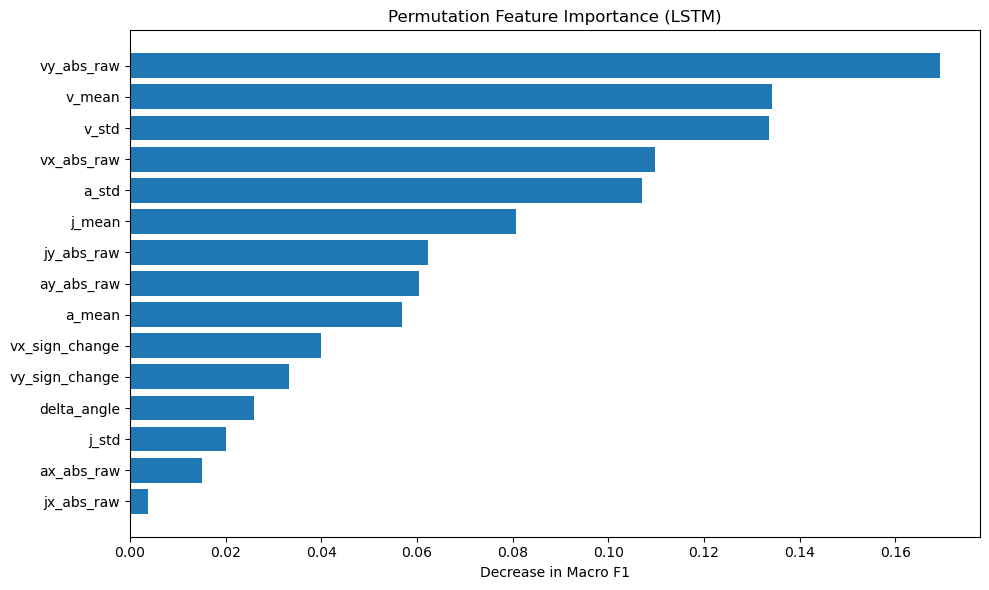

In [99]:
def permutation_feature_importance_lstm(
    model,
    X,
    y,
    metric_fn,
    n_repeats=3,
    batch_size=1024,
    random_state=42,
):
    """
    X shape: (samples, timesteps, features)
    Returns: importance array of shape (features,)
    """
    rng = np.random.RandomState(random_state)

    # Baseline score
    y_proba = model.predict(X, batch_size=batch_size, verbose=0)
    y_pred = y_proba.argmax(axis=1)
    baseline_score = metric_fn(y, y_pred)

    n_features = X.shape[-1]
    importances = np.zeros(n_features)

    for f in range(n_features):
        scores = []

        for _ in range(n_repeats):
            X_perm = X.copy()

            # Shuffle feature f **across samples**, keeping time structure
            perm_idx = rng.permutation(X_perm.shape[0])
            X_perm[:, :, f] = X_perm[perm_idx, :, f]

            y_proba_perm = model.predict(X_perm, batch_size=batch_size, verbose=0)
            y_pred_perm = y_proba_perm.argmax(axis=1)

            score = metric_fn(y, y_pred_perm)
            scores.append(score)

        importances[f] = baseline_score - np.mean(scores)

    return importances, baseline_score


# ====== Feature Importance (Permutation) ======
feature_importance, baseline_f1 = permutation_feature_importance_lstm(
    model=lstm,
    X=X_val_lstm,                # use validation set
    y=y_val_lstm,
    metric_fn=lambda y_true, y_pred: f1_score(
        y_true, y_pred, average="macro", zero_division=0
    ),
    n_repeats=5,
)

# Sort features by importance
feature_importance_df = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": feature_importance,
    })
    .sort_values("importance", ascending=False)
)

print("Baseline macro F1:", baseline_f1)
print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["feature"],
    feature_importance_df["importance"]
)
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (LSTM)")
plt.xlabel("Decrease in Macro F1")
plt.tight_layout()
plt.show()
